<a href="https://colab.research.google.com/github/j-min/IterInpaint/blob/main/iterinpaint_inference_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Apr 15 04:44:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/j-min/IterInpaint

Cloning into 'IterInpaint'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 136 (delta 43), reused 127 (delta 36), pack-reused 0
Receiving objects: 100% (136/136), 552.67 KiB | 5.70 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
cd IterInpaint

/content/IterInpaint


In [4]:
!pip uninstall -y torchtext

Found existing installation: torchtext 0.15.1
Uninstalling torchtext-0.15.1:
  Successfully uninstalled torchtext-0.15.1


In [5]:
!pip install -r requirements.txt -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.2/527.2 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 10.3 MB/s eta

In [6]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Loading model from diffusers checkpoint

In [8]:
model_id = 'j-min/IterInpaint-CLEVR'

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id)
pipe = pipe.to('cuda')

def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy
print("Disabled safety checker")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Disabled safety checker


# Define custom layout

In [9]:
layout_name = "eight_objects_two_rows"
custom_annotations = [
    {'x': 19,
     'y': 61,
     'width': 158,
     'height': 169,
     'label': 'blue metal cube'},
    {'x': 183,
      'y': 94,
      'width': 103,
      'height': 109,
      'label': 'brown rubber sphere'},
    {'x': 289,
     'y': 112,
     'width': 82,
     'height': 77,
     'label': 'gray metal sphere'},
    {'x': 374,
      'y': 128,
      'width': 48,
      'height': 46,
      'label': 'yellow rubber cylinder'},
    {'x': 22,
      'y': 346,
      'width': 82,
      'height': 73,
      'label': 'gray metal cylinder'},
    {'x': 110,
      'y': 326,
      'width': 107,
      'height': 102,
      'label': 'cyan rubber sphere'},
    {'x': 218,
      'y': 313,
      'width': 124,
      'height': 125,
      'label': 'green rubber cube'},
    {'x': 343,
      'y': 295,
      'width': 164,
      'height': 179,
      'label': 'red metal cylinder'},
]

In [10]:
from ldm.viz_utils import plot_results, fig2img, show_images
from ldm.gen_utils import encode_from_custom_annotation, iterinpaint_sample_diffusers

In [11]:
# 1) convert xywh to xyxy
# 2) normalize coordinates
scene = encode_from_custom_annotation(custom_annotations, size=512)

print(scene['boxes_normalized'])
print(scene['box_captions'])

[[0.037109375, 0.119140625, 0.345703125, 0.44921875], [0.357421875, 0.18359375, 0.55859375, 0.396484375], [0.564453125, 0.21875, 0.724609375, 0.369140625], [0.73046875, 0.25, 0.82421875, 0.33984375], [0.04296875, 0.67578125, 0.203125, 0.818359375], [0.21484375, 0.63671875, 0.423828125, 0.8359375], [0.42578125, 0.611328125, 0.66796875, 0.85546875], [0.669921875, 0.576171875, 0.990234375, 0.92578125]]
['blue metal cube', 'brown rubber sphere', 'gray metal sphere', 'yellow rubber cylinder', 'gray metal cylinder', 'cyan rubber sphere', 'green rubber cube', 'red metal cylinder']


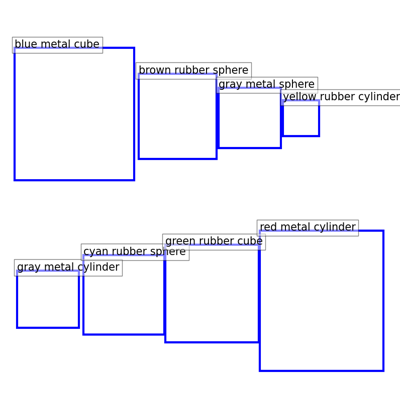

In [12]:
layout_img = fig2img(plot_results(
    Image.new('RGB', (512, 512), color='white'),
    boxes=scene['boxes_normalized'],
    captions=scene['box_captions'],
    colors=['blue'] * len(scene['box_captions'])
))
layout_img.resize((400,400))

# Generate Image

In [13]:
out = iterinpaint_sample_diffusers(pipe, scene, paste=True, verbose=True, size=512)

Initiailzed context image
Iter:  1 total:  8
Drawing  blue metal cube
prompt: Add blue metal cube


  0%|          | 0/50 [00:00<?, ?it/s]

Iter:  2 total:  8
Drawing  brown rubber sphere
prompt: Add brown rubber sphere


  0%|          | 0/50 [00:00<?, ?it/s]

Iter:  3 total:  8
Drawing  gray metal sphere
prompt: Add gray metal sphere


  0%|          | 0/50 [00:00<?, ?it/s]

Iter:  4 total:  8
Drawing  yellow rubber cylinder
prompt: Add yellow rubber cylinder


  0%|          | 0/50 [00:00<?, ?it/s]

Iter:  5 total:  8
Drawing  gray metal cylinder
prompt: Add gray metal cylinder


  0%|          | 0/50 [00:00<?, ?it/s]

Iter:  6 total:  8
Drawing  cyan rubber sphere
prompt: Add cyan rubber sphere


  0%|          | 0/50 [00:00<?, ?it/s]

Iter:  7 total:  8
Drawing  green rubber cube
prompt: Add green rubber cube


  0%|          | 0/50 [00:00<?, ?it/s]

Iter:  8 total:  8
Drawing  red metal cylinder
prompt: Add red metal cylinder


  0%|          | 0/50 [00:00<?, ?it/s]

Fill background
prompt: Add gray background


  0%|          | 0/50 [00:00<?, ?it/s]

Context images


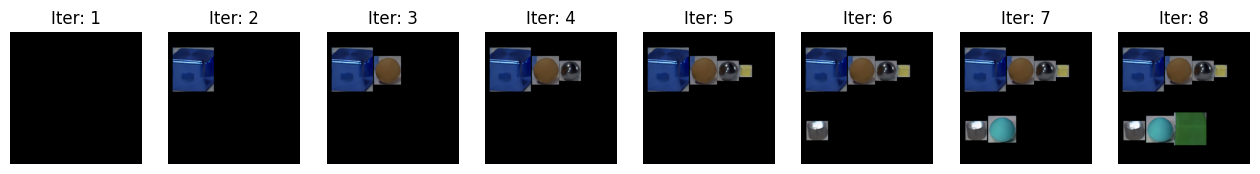

Masks - Black: preserved | White: repainted


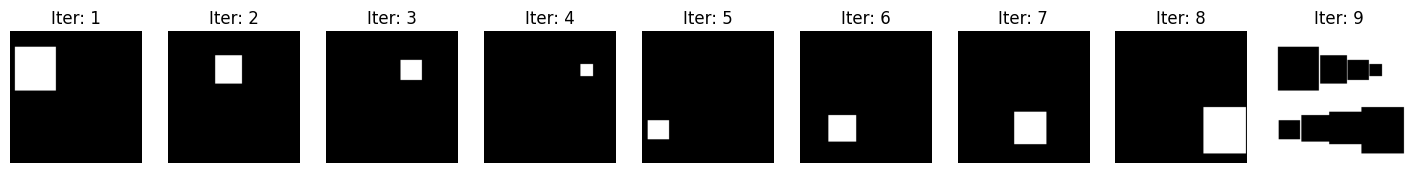

Generated_images


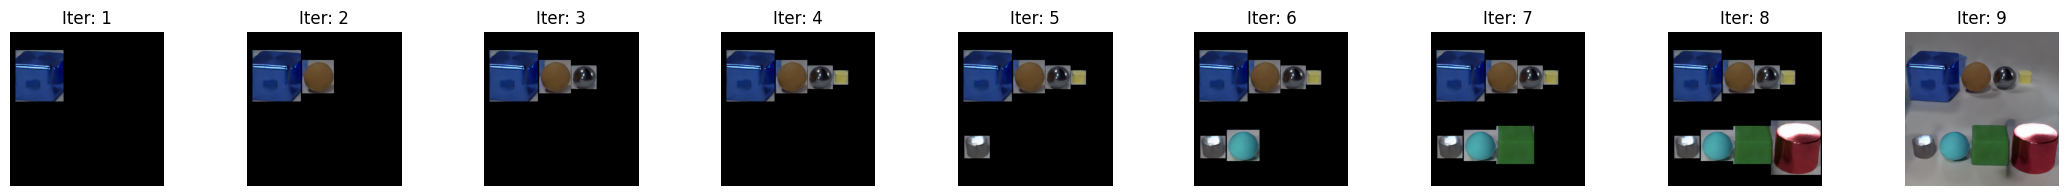

Generated_images - title: prompts


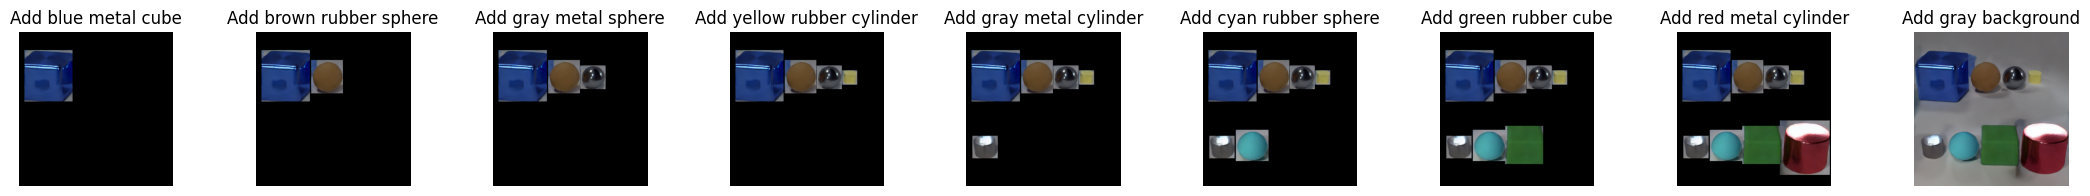

In [14]:
context_imgs = out['context_imgs']
prompts = out['prompts']
mask_imgs = out['mask_imgs']
generated_images = out['generated_images']

print('Context images')
show_images(context_imgs)
plt.show()
plt.close()


print('Masks - Black: preserved | White: repainted')
show_images(mask_imgs, gray=True)
plt.show()
plt.close()


print('Generated_images')
show_images(generated_images, w=3)
plt.show()
plt.close()

print('Generated_images - title: prompts')
show_images(generated_images, w=3, title=prompts)
plt.show()
plt.close()